# Librarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle

# Cargar caracteristicas

In [4]:
ruta = '../../Datos/DatosPANNS.pickle'

with open(ruta, 'rb') as data:
    unserialized_data = pickle.load(data)
    X_panns = unserialized_data['X']
    y_panns = unserialized_data['y']

In [5]:
X_tensor = torch.tensor(X_panns, dtype=torch.float)
Y_tensor = torch.tensor(y_panns, dtype=torch.uint8)

# GPU?

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creacion de grafos

In [7]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from torch_geometric.utils import index_to_mask
from random import sample, shuffle

In [8]:
tensor = torch.tensor(range(0,len(y_panns)))

In [9]:
l_val = sample(tensor.tolist(), round(len(y_panns) * 0.1))
val_mask = index_to_mask(torch.tensor(l_val), len(y_panns))

In [10]:
l_test = sample(tensor[~val_mask].tolist(), round(len(y_panns) * 0.1))
test_mask = index_to_mask(torch.tensor(l_test), len(y_panns))

In [11]:
l_train = val_mask + test_mask
train_mask = ~l_train

### Comprobar la distribución de los datos

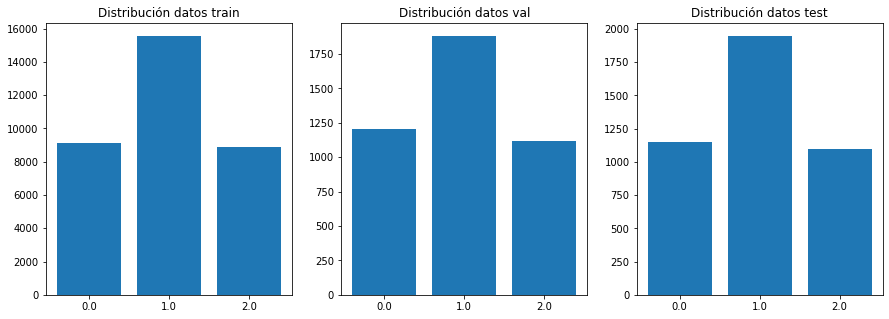

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(131), plt.bar(np.unique(y_panns), [np.sum(y_panns[train_mask] == 0.0),np.sum(y_panns[train_mask] == 1.0),np.sum(y_panns[train_mask] == 2.0)], tick_label = np.unique(y_panns)),plt.title('Distribución datos train')
plt.subplot(132), plt.bar(np.unique(y_panns), [np.sum(y_panns[val_mask] == 0.0),np.sum(y_panns[val_mask] == 1.0),np.sum(y_panns[val_mask] == 2.0)], tick_label = np.unique(y_panns)),plt.title('Distribución datos val')
plt.subplot(133), plt.bar(np.unique(y_panns), [np.sum(y_panns[test_mask] == 0.0),np.sum(y_panns[test_mask] == 1.0),np.sum(y_panns[test_mask] == 2.0)], tick_label = np.unique(y_panns)),plt.title('Distribución datos test')
plt.show()

In [13]:
#normalizacion
min = X_tensor[train_mask].min()
max = X_tensor[train_mask].max()
X_tensor_norm = (X_tensor - min) / (max - min)

In [14]:
x = X_tensor_norm

#Labels nodes

y = Y_tensor


#Se crea las conexines de los nodos

edge_index = knn_graph(x, k=4, batch=y, loop=False)


#Creacion del grafo 

data = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask, test_mask = test_mask, val_mask = val_mask)# edge_index tensor que define los nodos de origen y de destino.

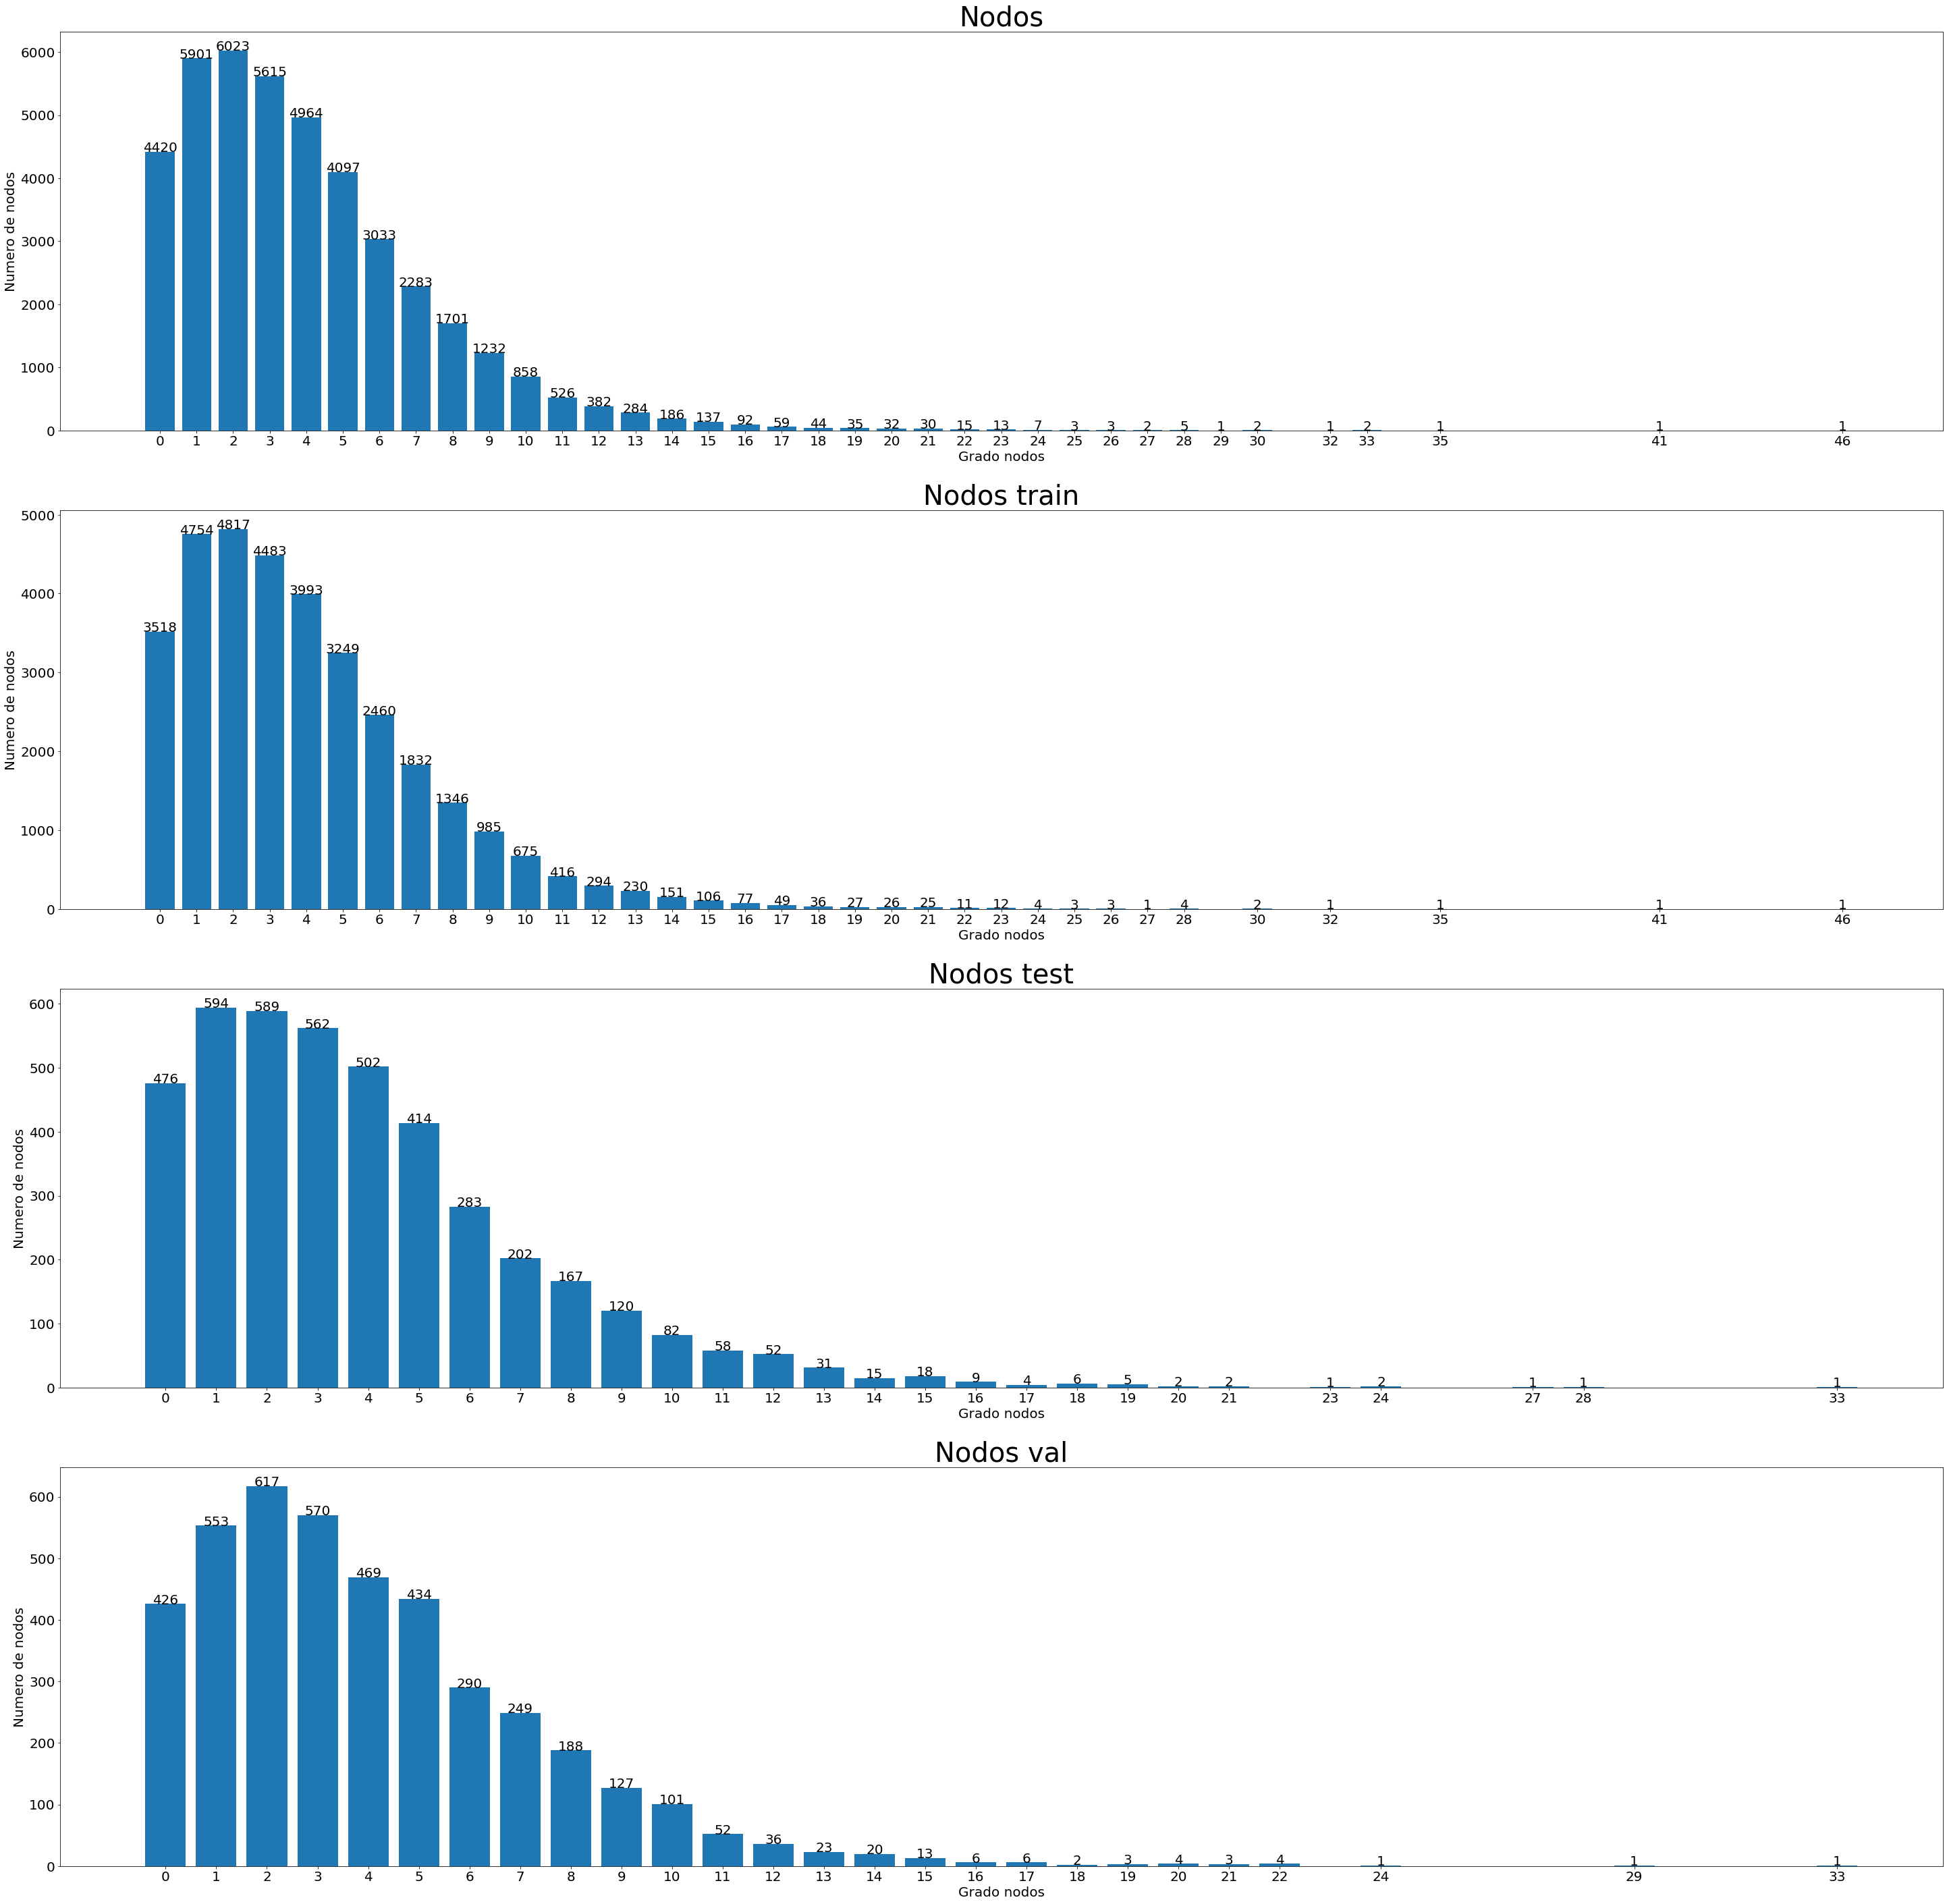

In [15]:
from torch_geometric.utils import degree
from collections import Counter


plt.figure(figsize = (50,50))
plt.rcParams.update({'font.size':20})

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

list_numbers_keys = list(map(lambda i: int(i), list(numbers.keys())))
list_numbers_values = list(map(lambda i: int(i), list(numbers.values())))

plt.subplot(411)

plt.title('Nodos',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_keys,list_numbers_values, tick_label = list_numbers_keys)




for i in range(len(list_numbers_keys)):

  plt.text(list_numbers_keys[i],list_numbers_values[i],list_numbers_values[i], ha='center')



degrees_train = degrees[train_mask]
numbers_train = Counter(degrees_train)


list_numbers_train_keys = list(map(lambda i: int(i), list(numbers_train.keys())))
list_numbers_train_values = list(map(lambda i: int(i), list(numbers_train.values())))

plt.subplot(412)

plt.title('Nodos train',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_train_keys,list_numbers_train_values, tick_label = list_numbers_train_keys)




for i in range(len(list_numbers_train_keys)):

  plt.text(list_numbers_train_keys[i],list_numbers_train_values[i],list_numbers_train_values[i], ha='center')


#====================================================================================================
degrees_test = degrees[test_mask]
numbers_test = Counter(degrees_test)


list_numbers_test_keys = list(map(lambda i: int(i), list(numbers_test.keys())))
list_numbers_test_values = list(map(lambda i: int(i), list(numbers_test.values())))



plt.subplot(413)

plt.title('Nodos test',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')


plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_test_keys,list_numbers_test_values, tick_label = list_numbers_test_keys)




for i in range(len(list_numbers_test_keys)):

  plt.text(list_numbers_test_keys[i],list_numbers_test_values[i],list_numbers_test_values[i], ha='center')


#====================================================================================================

degrees_val = degrees[val_mask]
numbers_val = Counter(degrees_val)


list_numbers_val_keys = list(map(lambda i: int(i), list(numbers_val.keys())))
list_numbers_val_values = list(map(lambda i: int(i), list(numbers_val.values())))

plt.subplot(414),

plt.title('Nodos val',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_val_keys,list_numbers_val_values, tick_label = list_numbers_val_keys)




for i in range(len(list_numbers_val_keys)):

  plt.text(list_numbers_val_keys[i],list_numbers_val_values[i],list_numbers_val_values[i], ha='center')

plt.show()

In [16]:
data.to(device)

Data(x=[41991, 2048], edge_index=[2, 167964], y=[41991], train_mask=[41991], test_mask=[41991], val_mask=[41991])

# Train Test Val

In [17]:
def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data, mask):
    
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[mask], data.y[mask])
    return acc

def train(model, data, epoch):
    
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = epoch

    model.train()
    for epoch in range(epochs+1):
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = f_loss(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        
        
        val_acc = test(model, data, data.val_mask)

        
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% |' f'Val Acc: {val_acc*100:.2f}%')
          
    return model

# Modelos

In [18]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

## GAT

In [19]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=10):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.8, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

In [20]:
gat = GAT(2048, 20, 3).to(device)

In [21]:
train(gat, data, epoch = 180)
ac = test(gat, data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.093 | Train Acc:  38.72% |Val Acc: 44.80%
Epoch  10 | Train Loss: 1.015 | Train Acc:  46.32% |Val Acc: 45.06%
Epoch  20 | Train Loss: 0.968 | Train Acc:  50.83% |Val Acc: 50.96%
Epoch  30 | Train Loss: 0.928 | Train Acc:  54.41% |Val Acc: 55.30%
Epoch  40 | Train Loss: 0.890 | Train Acc:  59.38% |Val Acc: 60.20%
Epoch  50 | Train Loss: 0.852 | Train Acc:  62.05% |Val Acc: 62.28%
Epoch  60 | Train Loss: 0.815 | Train Acc:  64.28% |Val Acc: 64.61%
Epoch  70 | Train Loss: 0.779 | Train Acc:  66.81% |Val Acc: 67.09%
Epoch  80 | Train Loss: 0.745 | Train Acc:  69.33% |Val Acc: 69.56%
Epoch  90 | Train Loss: 0.714 | Train Acc:  71.63% |Val Acc: 71.92%
Epoch 100 | Train Loss: 0.684 | Train Acc:  73.71% |Val Acc: 73.92%
Epoch 110 | Train Loss: 0.658 | Train Acc:  75.43% |Val Acc: 75.80%
Epoch 120 | Train Loss: 0.633 | Train Acc:  76.72% |Val Acc: 77.11%
Epoch 130 | Train Loss: 0.611 | Train Acc:  77.88% |Val Acc: 78.33%
Epoch 140 | Train Loss: 0.592 | Train Acc:  78.7

## GCN

In [22]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.8, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

In [23]:
gcn = GCN(2048, 10, 3).to(device)

In [24]:
train(gcn, data, epoch = 180)
ac = test(gcn, data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.091 | Train Acc:  40.99% |Val Acc: 45.99%
Epoch  10 | Train Loss: 1.055 | Train Acc:  46.31% |Val Acc: 44.80%
Epoch  20 | Train Loss: 1.040 | Train Acc:  46.31% |Val Acc: 44.80%
Epoch  30 | Train Loss: 1.025 | Train Acc:  46.32% |Val Acc: 44.84%
Epoch  40 | Train Loss: 1.010 | Train Acc:  47.46% |Val Acc: 46.49%
Epoch  50 | Train Loss: 0.996 | Train Acc:  48.35% |Val Acc: 47.49%
Epoch  60 | Train Loss: 0.982 | Train Acc:  49.26% |Val Acc: 48.51%
Epoch  70 | Train Loss: 0.969 | Train Acc:  50.34% |Val Acc: 49.80%
Epoch  80 | Train Loss: 0.955 | Train Acc:  51.54% |Val Acc: 51.08%
Epoch  90 | Train Loss: 0.942 | Train Acc:  52.87% |Val Acc: 52.30%
Epoch 100 | Train Loss: 0.930 | Train Acc:  54.16% |Val Acc: 53.54%
Epoch 110 | Train Loss: 0.918 | Train Acc:  55.43% |Val Acc: 54.94%
Epoch 120 | Train Loss: 0.906 | Train Acc:  56.40% |Val Acc: 56.35%
Epoch 130 | Train Loss: 0.894 | Train Acc:  57.46% |Val Acc: 57.63%
Epoch 140 | Train Loss: 0.882 | Train Acc:  58.8

## SAGE

In [25]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.8)
        h = self.conv2(h, edge_index)
       
        return h

In [26]:
g_sage = GraphSAGE(2048, 30, 3).to(device)

In [27]:
train(g_sage, data, epoch = 180)
ac = test(g_sage, data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.105 | Train Acc:  28.45% |Val Acc: 36.29%
Epoch  10 | Train Loss: 1.056 | Train Acc:  46.21% |Val Acc: 44.46%
Epoch  20 | Train Loss: 1.036 | Train Acc:  46.20% |Val Acc: 45.18%
Epoch  30 | Train Loss: 1.017 | Train Acc:  46.74% |Val Acc: 45.80%
Epoch  40 | Train Loss: 0.997 | Train Acc:  47.81% |Val Acc: 47.39%
Epoch  50 | Train Loss: 0.978 | Train Acc:  49.49% |Val Acc: 49.08%
Epoch  60 | Train Loss: 0.953 | Train Acc:  50.97% |Val Acc: 51.39%
Epoch  70 | Train Loss: 0.937 | Train Acc:  53.03% |Val Acc: 52.39%
Epoch  80 | Train Loss: 0.921 | Train Acc:  54.67% |Val Acc: 53.92%
Epoch  90 | Train Loss: 0.902 | Train Acc:  56.34% |Val Acc: 55.44%
Epoch 100 | Train Loss: 0.890 | Train Acc:  58.03% |Val Acc: 57.30%
Epoch 110 | Train Loss: 0.879 | Train Acc:  58.90% |Val Acc: 59.68%
Epoch 120 | Train Loss: 0.870 | Train Acc:  59.67% |Val Acc: 59.61%
Epoch 130 | Train Loss: 0.858 | Train Acc:  60.94% |Val Acc: 60.40%
Epoch 140 | Train Loss: 0.847 | Train Acc:  61.8